Here we seek to solve
\begin{align}
\min_{(u,\rho)\in\mathcal{V}\times\mathcal{M}}J(u,\rho)&:=\frac{1}{2}\int_{\Omega}(u-u_{d})^{2}\mathrm{d}V+\frac{1}{2}R(\rho)\\
R(\rho)&:=\int_{\Omega}(\gamma_{1}\,\rho^{2}+\gamma_{2}\nabla \rho\cdot\nabla \rho)\mathrm{d}V
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\nabla\cdot\left(\rho\,\nabla u\right)+\beta\, u&=f,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and bound constraint

\begin{align*}
\rho(x)\geq \rho_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $\rho_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}_{\geq 0}$ are given.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSparseMultigrid import interior_pt
from hippylib import nb

from helperfunctions import *

from problems import inverseDiffusion

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

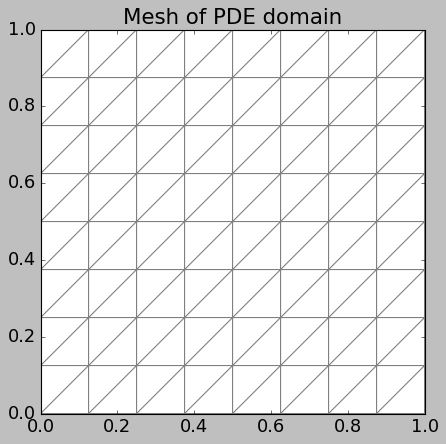

In [3]:
nx_coarse = 4 
nx = 8

# coarse and fine meshes
mesh_coarse = dl.UnitSquareMesh(nx_coarse, nx_coarse)

mesh_fine   = dl.UnitSquareMesh(nx, nx)

meshes = [mesh_coarse, mesh_fine]
mesh   = meshes[-1]
lvl    = len(meshes) # depth of mesh hierarchy
dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [4]:
P1_deg = 1 # degree of finite-element polynomials for parameter (rho)
P2_deg = 2 # degree of finite-element polynomials for state

P1s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), P1_deg) for i in range(lvl)]
P2s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), P2_deg) for i in range(lvl)] 
Ths  = [dl.MixedElement([P2s[i], P1s[i]]) for i in range(lvl)]
Vhs  = [dl.FunctionSpace(meshes[i], Ths[i]) for i in range(lvl)]
Vh1s = [dl.FunctionSpace(meshes[i], P1s[i]) for i in range(lvl)]
Vh2s = [dl.FunctionSpace(meshes[i], P2s[i]) for i in range(lvl)]

P1  = P1s[-1]
P2  = P2s[-1]
Th  = Ths[-1]
Vh  = Vhs[-1]
Vh1 = Vh1s[-1]
Vh2 = Vh2s[-1]

print("dim(state) = {0:d}, dim(parameter) = {1:d}".format(Vh.sub(0).dim(), Vh.sub(1).dim()))

dim(state) = 289, dim(parameter) = 81


In [5]:
beta   = 1.
gamma1 = 1.e-4
gamma2 = 1.e-4
Crhol  = 0.75


rhols = [dl.interpolate(dl.Expression('C', element=Vh1s[i].ufl_element(), C=Crhol), Vh1s[i]).vector().get_local() \
         for i in range(lvl)]
uds   = [dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                          pi=np.pi, element=Vh2s[i].ufl_element()), Vh2s[i]) \
         for i in range(lvl)]
gs   =  [dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                          '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                           pi=np.pi, beta=beta, element=Vh2s[i].ufl_element()), Vh2s[i]) \
         for i in range(lvl)]

problems = [inverseDiffusion(Vhs[i], Vh1s[i], Vh2s[i], beta, gamma1, gamma2, uds[i], gs[i], rhols[i]) \
           for i in range(lvl)]

rhol = rhols[-1]
ud   = uds[-1]
g    = gs[-1]
problem = problems[-1]

rhotrue = dl.interpolate(dl.Expression('0.5+x[0]',\
                                      element=Vh1.ufl_element()), Vh1)

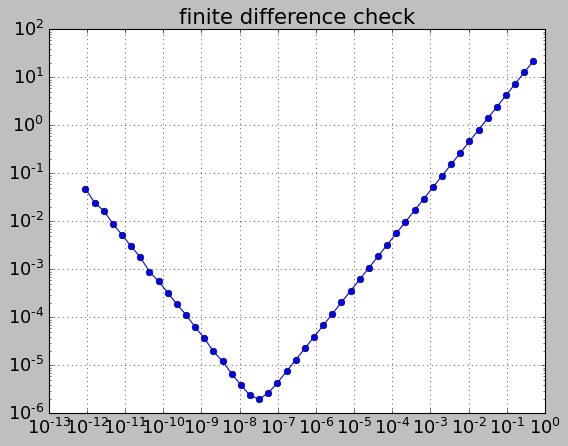

In [6]:
# ---- gradient check   
    
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)

# initial point
x0 = np.array([1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + rhol[i-Vh2.dim()]) for i in range(Vh.dim())])
xhat = np.random.randn(Vh.dim()) 


grad_check(F, gradF, x0, xhat)

In [13]:
solver = interior_pt(problems)
x0      = np.ones(problem.n)
x0[:problem.n1] = problem.restore_feasibility(x0)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
mu0    = 1.e0
opttol = 1.e-10
max_it = 30
Xf, mu, E, Mus = solver.solve(opttol, max_it, mu0)
xf, lamf, zf = Xf[:]

-------------------------------------------------- it = 0
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
solved barrier problem (mu = 2.500e-01)
solved barrier problem (mu = 1.250e-01)
-------------------------------------------------- determining search direction 
KKT sys error = 1.279e-14
GMRES iterations = 3
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.531e-01
in filter region?  False
A.5.4
theta(x) = 3.85e-14
angle between xhat and Dxphi = 135.3 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 4.419e-02)
solved barrier problem (mu = 9.291e-03)
-------------------------------------------------- determining search direction 
KKT sys error = 6.312e-12
GMRES iterations = 4
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.515e-0

-------------------------------------------------- determining search direction 
KKT sys error = 2.147e-07
GMRES iterations = 12
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 3.24e-08
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 17
solved barrier problem (mu = 5.167e-11)
-------------------------------------------------- determining search direction 
KKT sys error = 3.554e-12
GMRES iterations = 20
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 2.49e-10
angle between xhat and Dxphi = 92.9 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
---------

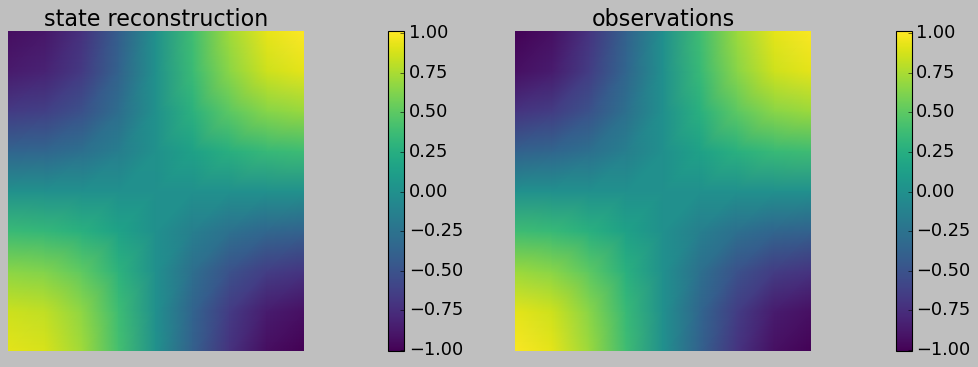

In [14]:
uReconstruction   = dl.Function(Vh2)
lamReconstruction = dl.Function(Vh2)

rhoReconstruction = dl.Function(Vh1)
zReconstruction   = dl.Function(Vh1)

uReconstruction.vector()[:]   = xf[:problem.n1]
rhoReconstruction.vector()[:] = xf[problem.n1:]

lamReconstruction.vector()[:] = lamf[:]
zReconstruction.vector()[:]   = zf[:]

nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
plt.show()

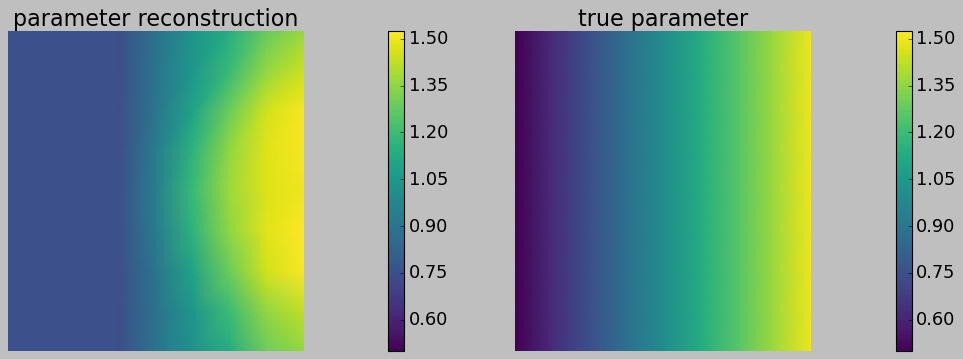

In [15]:
nb.multi1_plot([rhoReconstruction, rhotrue], ["parameter reconstruction", "true parameter"])
plt.show()

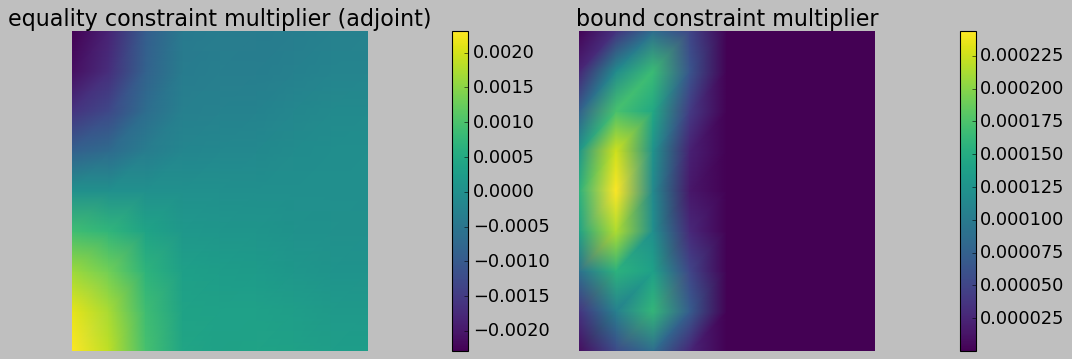

1.29e-11 <= z <= 2.44e-04
portion of bound constraint dofs below tol = 0.56


In [16]:
nb.multi1_plot([lamReconstruction, zReconstruction], \
            ["equality constraint multiplier (adjoint)", "bound constraint multiplier"],\
            same_colorbar=False)
plt.show()

print("{0:1.2e} <= z <= {1:1.2e}".format(min(zf), max(zf)))
print("portion of bound constraint dofs below tol = {0:1.2f}".format(sum(zf < opttol)/len(zf)))

In [ ]:
Es = [[E[i][j] for i in range(len(E))] for j in range(len(E[0]))]
labels = ["optimality error", "stationarity", "feasibility", "complementarity"]

for i in range(1,4):
    plt.plot(Es[i], label=labels[i], linewidth=2.0)
    plt.yscale('log')
plt.legend(loc = 'lower center')
plt.grid()
plt.title('convergence history')
plt.show()

In [ ]:
hierarchy = multigridHierarchy(problems)
hierarchy.constructPreconditioner(Xf)
mu = Mus[-1]
print("mu final = {0:1.2e}".format(mu))

In [ ]:
rk = np.zeros(problem.n + problem.m)
Ak, Jk, drk = solver.formH(Xf, mu)
JkT = Jk.transpose()
rk[:problem.n] = problem.Dxf(Xf[0]) + JkT.dot(Xf[1])
rk[problem.n:] = problem.c(Xf[0])
rk[problem.n1:problem.n] += drk[:]
Wk = Ak[:problem.n, :problem.n]
constrainedSlumped = ConstrainedSmoother(Wk, JkT, Jk, problem.n1, lumped=True)
constrainedS       = ConstrainedSmoother(Wk, JkT, Jk, problem.n1)

Spre               = ConstrainedPreSmoother(Wk, JkT, Jk, problem.n1)
Spost              = ConstrainedPostSmoother(Wk, JkT, Jk, problem.n1)

constrainedApproximate = ApproximateConstrainedSmoother(Wk, JkT, Jk, problem.n1)

smoothers = [hierarchy.S, constrainedS, constrainedSlumped, \
             constrainedApproximate, Spre, np.identity(Ak.shape[0])]

postsmoothers = [None, None, None, None, Spost, None]

smoother_labels = ["Uzawa", "Constrained", "Constrained+lumped", "Approx Constrained", "Pre/Post", "Identity"]

In [ ]:
smoothing_steps_set = [1, 2, 4]
lintol  = 1.e-12
maxiter = 75
restart = 20
krylov_convergence = Krylov_convergence(Ak, -rk)
gmres = True


residuals_twogrids = [[[] for j in range(len(smoothers))] for i in smoothing_steps_set]


for i, smoothing_steps in enumerate(smoothing_steps_set):
    for j, S in enumerate(smoothers):
        #if j == 0 or j==2 or j==3 or j==4:
        #    continue
        print('\n\n')
        print(smoother_labels[j])
        krylov_convergence.reset()
        # ---- GMRES-twogrid solve
        two_grid_P = two_grid_action(hierarchy.Lfine, hierarchy.Lcoarse, S, hierarchy.P, hierarchy.R, \
                             smoothing_steps, Spost= postsmoothers[j])
        if gmres:
            u, info = spla.gmres(Ak, -rk, tol=lintol, atol=lintol, \
                              M = two_grid_P, maxiter=maxiter, restart=restart, callback=krylov_convergence.callback)
        else:
            u, info = spla.lgmres(Ak, -rk, tol=lintol, atol=lintol, \
                              M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
            #u, info = spla.minres(Ak, -rk, tol=lintol,
            #                     M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
        residuals_twogrid = np.array(krylov_convergence.residuals).copy()
        residuals_twogrids[i][j] = residuals_twogrid
        final_residual = np.linalg.norm(Ak.dot(u)+rk)
        final_relative_residaul = final_residual / np.linalg.norm(rk)
        its = len(residuals_twogrid)
        if its < maxiter:
            print("-"*50)
            print("two grid scheme with "+smoother_labels[j]+" smoothing converged in {0:d} iterations".format(its))
        residual = -rk - Ak.dot(u)
        print("final residual norm = {0:1.2e}".format(np.linalg.norm(residual)))
        print("final relative residual norm = {0:1.2e}".format(np.linalg.norm(residual)/np.linalg.norm(rk)))
        print("info = ", info)
        print('\n\n')
        
# ---- GMRES with no preconditioner
if gmres:
    u, info = spla.gmres(Ak, -rk, tol=lintol, atol=lintol, \
                   maxiter=maxiter, restart=restart, callback=krylov_convergence.callback)
else:
    u, info = spla.lgmres(Ak, -rk, tol=lintol, atol=lintol, \
                   maxiter=maxiter, callback=krylov_convergence.callback)
residuals_noP = np.array(krylov_convergence.residuals).copy()



In [ ]:
for j, label in enumerate(smoother_labels):
    for i, smoothing_steps in enumerate(smoothing_steps_set):
        plt.plot(residuals_twogrids[i][j], label='{0:d} pre/post smoothing steps'.format(smoothing_steps), linewidth=2.0)
    plt.plot(residuals_noP, 'k', label='no preconditioner', linewidth=2.0)
    plt.yscale('log')
    plt.ylabel(r'$||A\,x_{k}-b||/||b||$, relative residual norm')
    plt.title('Linear system convergence history')
    plt.xlim([0,50])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid()
    plt.title(label+' smoothing ')
    plt.show()

We next investigate the IP-Newton system matrix, with block structure
$$
A = \begin{pmatrix}
W & J^{\top} \\
J & 0
\end{pmatrix}
$$
where $J$ is the constraint Jacobian and $W$ is the Hessian of the Lagrangian with an interior-point perturbation.

In [ ]:
test = dl.TestFunction(Vh2)
trial = dl.TrialFunction(Vh2)
M = dl.assemble(test*trial*dl.dx(Vh2.mesh())).array()
one = np.ones(M.shape[0])
Mlumped = M.dot(one)
print("{0:1.2e} <= (M_lumped)_(i,i) <= {1:1.2e}".format(min(Mlumped), max(Mlumped)))

Mfunc = dl.Function(Vh2)
Mfunc.vector()[:] = M.dot(one)

nb.plot(Mfunc)
plt.title("lumped mass matrix")
plt.show()


In [ ]:
condAk = np.linalg.cond(Ak.todense())
condWk = np.linalg.cond(Ak.todense()[:problem.n,:problem.n])
eigWk  = np.linalg.eigvals(Ak.todense()[:problem.n,:problem.n])

JWJT = (Jk.todense().dot(Ak.todense()[:problem.n, :problem.n]).dot(JkT.todense()))

condJJT = np.linalg.cond(Jk.dot(JkT).todense())
print("cond(A) = {0:1.2e}".format(condAk))
print("cond(W) = {0:1.2e}".format(condWk))
print("minimum eigenvalue of W = {0:1.2e}".format(min(eigWk)))
print("cond(J J^T) = {0:1.2e}".format(condJJT))

We next investigate the quality of the two-grid preconditioner with Uzawa smoothing.
The preconditioned matrix $P\,A$, is desired/expected to be well conditioned and that it is approximately equal to an identity matrix.

In [ ]:
smoothing_steps = 1
ei = np.zeros(Ak.shape[0])
SAs = [np.zeros(Ak.shape) for j in range(len(smoothers))]
eigIminusSAs = [None for j in range(len(smoothers))]


for j, S in enumerate(smoothers):
    for i in range(Ak.shape[0]):
        ei[i] = 1.0
        SAs[j][:,i] = S.dot(Ak.dot(ei))
        ei[i] = 0.0
    eigIminusSAs[j] = np.abs(1. - np.linalg.eigvals(SAs[j]))
    args = np.argsort(eigIminusSAs[j])
    eigIminusSAs[j] = eigIminusSAs[j][args[::-1]]
    print("spectral radius (I- SA) = {0:1.2e} (".format(max(eigIminusSAs[j]))+smoother_labels[j]+" smoothing)")

for j, label in enumerate(smoother_labels):
    if j == 0 or j == 2 or j == 5:
        continue
    plt.plot(eigIminusSAs[j], label=label, linewidth=2.0)
plt.plot(np.ones(Ak.shape[0]), '--k', label='1', linewidth=2.0)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$| 1 -\lambda(SA)|$')
plt.title(r'eigenvalue magnitudes of $I-S\,A$')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.xlim([1, 3*len(eigIminusSAs[j])])
plt.ylim([1.e-10, np.max(eigIminusSAs)])
plt.show()


In [ ]:
W = Ak[:problem.n, :problem.n].todense()
Wum = W[:problem.n1, problem.n1:]
Wuu = W[:problem.n1, :problem.n1]
Wmm = W[problem.n1:, problem.n1:]



plt.imshow(Wum)
plt.title(r'entries of $\left(W_{u,m}\right)_{i,j}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$j$')
plt.colorbar()
plt.show()

plt.imshow(Wuu)
plt.title(r'entries of $\left(W_{u,u}\right)_{i,j}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$j$')
plt.colorbar()
plt.show()

plt.imshow(Wmm)
plt.title(r'entries of $\left(W_{m,m}\right)_{i,j}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$j$')
plt.colorbar()
plt.show()


def compute_eigs(Wblock, label):
    eigs = np.linalg.eigvals(Wblock)
    eig_real = [eig.real for eig in eigs]
    eig_imag = [eig.imag for eig in eigs]
       
    #unit_circle = np.array([[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2.*np.pi)])
    plt.plot(eig_real, eig_imag, '*')
    plt.title(r'complex eigenvalues of '+label)
    plt.xlabel('real axis')
    plt.ylabel('imaginary axis')
    #plt.plot(unit_circle[:,0], unit_circle[:,1])
    print('{0:1.2e} <= real(lambda) <= {1:1.2e}'.format(min(eig_real), max(eig_real)))    
    plt.show()

print("*"*50)
compute_eigs(Wuu, '$W_{u,u}$')
print("*"*50)
compute_eigs(Wmm, '$W_{m,m}$')
print("*"*50)
if P1_deg == P2_deg:
    compute_eigs(Wum, '$W_{u,m}$')
    print("*"*50)